In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import random
import io
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# https://www.kaggle.com/datasets/mykras/ukrainian-texts
path = "Lys_mykyta.txt"
# Read and process the text
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")
print("Corpus length:", len(text))

# Create character-to-index and index-to-character mappings
chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}

# Cut the text into sequences of maxlen characters with a set step size
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

# Initialize tensors for the input and output data
x = torch.zeros(len(sentences), maxlen, len(chars), dtype=torch.bool)
y = torch.zeros(len(sentences), len(chars), dtype=torch.bool)

# Populate the input tensor `x` and output tensor `y`
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Corpus length: 86526
Total chars: 49
Number of sequences: 28829


In [14]:
x.shape

torch.Size([28829, 40, 49])

In [25]:
y.shape

torch.Size([28829, 49])

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define the LSTM model class
class TextGenerationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TextGenerationModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # Only using the final hidden state
        output = self.fc(h_n[-1])  # Apply final linear layer
        return output


# Initialize model parameters
input_size = len(chars)  # Vocabulary size (number of unique characters)
hidden_size = 128  # Number of LSTM units
output_size = len(chars)  # Output size matches the vocabulary size

# Instantiate the model
model = TextGenerationModel(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

In [8]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [30]:
epochs = 10
batch_size = 128

# Training loop
# Convert `y` to class indices to match CrossEntropyLoss requirements
y_indices = torch.argmax(y.to(torch.float16), dim=1)

# Training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    # Batch processing with clone().detach() and class index targets
    for i in range(0, len(x), batch_size):
        x_batch = x[i : i + batch_size].clone().detach().float()
        y_batch = y_indices[i : i + batch_size].clone().detach().long()

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / (len(x) // batch_size):.4f}")

    print("Generating text after epoch:", epoch)

    # Text generation
    model.eval()
    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        # Convert the initial sentence to a tensor
        for _ in range(400):
            x_pred = torch.zeros((1, maxlen, len(chars)), dtype=torch.float32)
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0

            # Generate predictions
            with torch.no_grad():
                preds = model(x_pred)
                preds = nn.functional.softmax(preds[0], dim=0)

            # Sample the next character index based on diversity
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            # Update the sentence and generated text
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

Epoch 1/10, Loss: 2.2985
Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "і дари заграбував?  а тепер, царице-мамо"
...Generated:   ти притав.  – лись зались вовка та притомав.  – та притав.  – від не такита притав.  – та микита мене притарить притав.  – притав.  – та притав.  – притодав.  – приторать – від мерене та притав.  – притав..  – та притовав.  – притав.  – та притав.  – маже та притав.  – та приторав..  лис мене не тимає, а та притав.  – та прилав... – та притарав.  – лис сладав.  – вірти та притав.  – притав.  в ли
-
...Diversity: 0.5
...Generating with seed: "і дари заграбував?  а тепер, царице-мамо"
...Generated:   мерели – лиси, віда слілить дуже ти жать гаже!  – та й кумив.  у мере на пачеть – як микита, пи дарить залишить дуже вільки малить такити щу жерав.  – гарем в від слара, вовки сарелись. – – лиси залиди й буде, – на таже та думить – та в лишить.  лис від дуте в кавав.  «хочить та листи залися притовив.  – притоди не там вас заладу палати

In [ ]:
# model - https://huggingface.co/Strongich/bert-english-ner-mountain
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Strongich/bert-english-ner-mountain")
model = AutoModelForTokenClassification.from_pretrained(
    "Strongich/bert-english-ner-mountain"
)

nlp = pipeline("ner", model=model, tokenizer=tokenizer, device=device)
example = "The sun dipped below the horizon, casting a warm glow upon the rugged slopes of Mount Everest."

ner_results = nlp(example)
print(ner_results)

[{'entity': 'B-Mountain', 'score': 0.8396509, 'index': 17, 'word': 'Mount', 'start': 80, 'end': 85}, {'entity': 'I-Mountain', 'score': 0.9836849, 'index': 18, 'word': 'Everest', 'start': 86, 'end': 93}]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

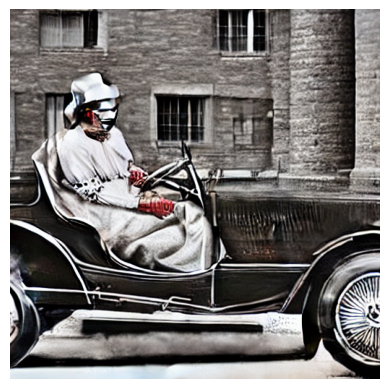

In [4]:
from diffusers import StableDiffusionPipeline
import torch

torch.cuda.empty_cache()

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Generate an image based on the prompt
prompt = "a photo of a knight sitting in an old Mercedes car"
image = pipe(prompt, num_inference_steps=5).images[0]

# Plot the image using matplotlib
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()